# 18b. Green band stratigraphy U1313
This notebook makes the supplementary document that shows the green%, Fe/Ti, and demarcates the depths designed as green bands for Site U1313.
## Setup
### Import modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
# %matplotlib inline
from scipy import signal,interpolate,stats,linalg
from IPython.display import clear_output
import time
import numpy as np
import seaborn as sns
from PIL import Image
from matplotlib.ticker import AutoMinorLocator
from matplotlib.patches import Patch

### Set Paths

In [2]:
data_path='/Users/danielbabin/GitHub/Green_Bands/Data/'
table_path='/Users/danielbabin/GitHub/Green_Bands/Tables/'
core_photos='/Volumes/SanDisk.Data/IODP1313CorePhotos/Cropped/'
filtered_photos='/Volumes/SanDisk.Data/IODP1313CorePhotos/Filtered/'

### Import data
#### Green%

In [10]:
green=pd.read_csv(table_path+'Supplementary Table 5B - U1313 green intensity splice.csv',index_col='CCSF Depth (m)')
green['SectionLabel']=(green['Site'].map(str)+green['Hole']+'_'+
                              green['Core'].map(str)+green['Type']+green['Section'].map(str))
green=green[green.index.duplicated()==False]
green=green.sort_index()
channel_cols=green.columns[7:-2]

#### Green bands

In [11]:
green_layers=pd.read_csv(table_path+'Supplementary Table 6B - U1313 green bands.csv')
green_layers=green_layers[green_layers['Label']>0].copy()
green_layers['Label']=green_layers['Label'].astype(int)

#### Splice info

In [12]:
splice=pd.read_csv(data_path+'SpliceTables/cleanSpliceConstruction1313.csv')
splice['CoreLabel']=(splice['Site'].map(str).str.strip()+splice['Hole'].str.strip()+'_'+splice['Core'].map(str))

section_list=pd.read_csv(data_path+'SectionSummaries/spliceSections1313.csv')
section_list['SectionLabel']=(section_list['Site'].map(str)+section_list['Hole']+'_'+
                              section_list['Core'].map(str)+section_list['Type']+
                              section_list['Section'].map(str))
section_list=section_list.set_index('SectionLabel',drop=False)
section_list=section_list[(section_list['Top(mcd)']<95)&
                      (section_list['Section']!='CC')]
sections=section_list['SectionLabel'].reset_index(drop=True)

## Core Photos

In [13]:
raws={}
filts={}
start=time.time()
for i,file in enumerate(section_list['Filename']):
    clear_output(wait=True)
    section_label=section_list.index[i]
    handle=sections[i]
    raws[handle] = Image.open(core_photos+file)
    filts[handle] = Image.open(filtered_photos+file)
    
    stop=time.time()-start
    if i/len(section_list)*100<2:
        expected_time='Calculating...'
    else:
        expected_time=np.round((stop-0)/(i/len(section_list))/60,2)
    print('Current progress: ',np.round(i/len(section_list)*100,2),'%')
    print('Current run time: ',np.round((stop-0)/60,2),' minutes')
    print('Expected run time: ',expected_time,' minutes')

Current progress:  98.78 %
Current run time:  0.0  minutes
Expected run time:  0.0  minutes


In [14]:
aspects=[]
for i,sect in enumerate(sections):
    shp=raws[sect].size
    aspects.append(shp[0]/shp[1])
aspects=np.array(aspects)
naspests=((16.6/aspects)-1)/2

## Results PDF

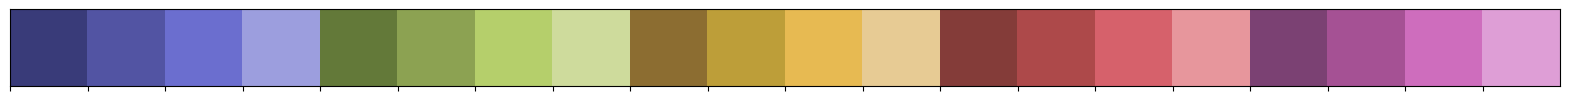

In [15]:
colors=sns.color_palette('tab20b')
sns.palplot(colors)

### Test Figures
#### Four Logs
I'm keeping this just in case I ever want to use it

In [16]:
green_colors_no_alpha=['#f0ebf2','#edf6f5','#fdfced']

In [17]:
### setup gridspec
def makeLog(number,position):
    
    sect=sections[number]
    filename=section_list.loc[sections[number],'Filename']
    rphot = Image.open(core_photos+filename)
    fphot = Image.open(filtered_photos+filename)
    aspect=rphot.size[0]/rphot.size[1]
    
    if position=='left':
        cax1=fig.add_subplot(gs[:,0])
        cax2=fig.add_subplot(gs[:,1])
        ax2=fig.add_subplot(gs[:,2:4])
    elif position=='center':
        cax1=fig.add_subplot(gs[:,6])
        cax2=fig.add_subplot(gs[:,7])
        ax2=fig.add_subplot(gs[:,8:10])
    else:
        cax1=fig.add_subplot(gs[:,12])
        cax2=fig.add_subplot(gs[:,13])
        ax2=fig.add_subplot(gs[:,14:16])   

    ### despine
    sns.despine(ax=ax2,top=False,bottom=True,left=True,right=True)
    for ax in [ax2]:        
        ax.patch.set_alpha(0)
        ax.yaxis.set_visible(False)

    ### Title
    if position=='left':
        cax1.annotate(sect[:3]+' Hole '+sect[4]+' '+sect[6:]+'\nSplice Sect '+str(number+1)+'/82',
                     xy=(.5,1.1),xycoords='axes fraction',
                     verticalalignment='center',horizontalalignment='left',
                     size=12,fontweight='bold')
    if position=='center':
        cax1.annotate(sect[:3]+' Hole '+sect[4]+' '+sect[6:]+'\nSplice Sect '+str(number+1)+'/82',
                     xy=(.5,1.1),xycoords='axes fraction',
                     verticalalignment='center',horizontalalignment='left',
                     size=12,fontweight='bold')
    else:
        cax1.annotate(sect[:3]+' Hole '+sect[4]+' '+sect[6:]+'\nSplice Sect '+str(number+1)+'/82',
                     xy=(.5,1.1),xycoords='axes fraction',
                     verticalalignment='center',horizontalalignment='left',
                     size=12,fontweight='bold')

    ### setup columns
    green_data=green.loc[green['SectionLabel']==sect,'Green%']

    ### Image
    sect_length=(section_list.loc[sect,'Bottom(mcd)']-
                  section_list.loc[sect,'Top(mcd)'])
    extentlist=[0,sect_length/aspect,
                section_list.loc[sect,'Bottom(mcd)'],
               section_list.loc[sect,'Top(mcd)']]
    
    cax1.imshow(rphot.rotate(270, Image.NEAREST, expand = 1),extent=extentlist)
    sns.despine(ax=cax1,top=True,bottom=True,left=False,right=True)
    cax1.xaxis.set_visible(False)
    cax1.set_ylabel('Depth CCSF (m)')
    
    cax2.imshow(fphot.rotate(270, Image.NEAREST, expand = 1),extent=extentlist)
    sns.despine(ax=cax2,top=True,bottom=True,left=False,right=True)
    cax2.xaxis.set_visible(False)
    cax2.yaxis.set_visible(False)

    ### Actual Plots
    ax2.plot(green_data.values,green_data.index,color='k',lw=.5)

    ### coloring
    sect_top=section_list.loc[sect,'Top(mcd)']
    sect_bottom=section_list.loc[sect,'Bottom(mcd)']
    
    if aspect<17:
        l_limit=0.05
    else:
        l_limit=0
        
    sect_green=green_layers.loc[(green_layers['Top Depth CCSF (m)']>=sect_top-.1)&
                            (green_layers['Bottom Depth CCSF (m)']<=sect_bottom+.1)&
                            (green_layers['Top Depth CCSF (m)']>=green_data.index.min()-.1)&
                            (green_layers['Bottom Depth CCSF (m)']<=green_data.index.max()+.1)]
    for gl in sect_green.index:
        if sect_green.loc[gl,'Label']==2:
            c=green_colors_no_alpha[0]
            for ax in [ax2]:
                ax.axhspan(ymin=sect_green.loc[gl,'Bottom Depth CCSF (m)'],
                           ymax=sect_green.loc[gl,'Top Depth CCSF (m)'],
                           color=c,zorder=-1)
        elif sect_green.loc[gl,'Label']==3:
            c=green_colors_no_alpha[1]
            for ax in [ax2]:
                ax.axhspan(ymin=sect_green.loc[gl,'Bottom Depth CCSF (m)'],
                           ymax=sect_green.loc[gl,'Top Depth CCSF (m)'],
                           color=c,zorder=-1)
        elif sect_green.loc[gl,'Label']==4:
            c=green_colors_no_alpha[2]
            for ax in [ax2]:
                ax.axhspan(ymin=sect_green.loc[gl,'Bottom Depth CCSF (m)'],
                           ymax=sect_green.loc[gl,'Top Depth CCSF (m)'],
                           color=c,zorder=-1)


    ### Labels
    ax2.set_xlabel('Green%')
    ax2.xaxis.set_label_position('top')
    ax2.set_ylabel('Depth CCSF (m)')
    
    for ax in [ax2]:
        minor_locator = AutoMinorLocator(2)
        ax.xaxis.set_minor_locator(minor_locator)
    for ax in [cax1,ax2]:
        minor_locator = AutoMinorLocator(2)
        ax.yaxis.set_minor_locator(minor_locator)
    
    ### xlims
    ax2.set_xlim(0,100)
        
    ### ylims
    for i,a in enumerate([ax2]):
        a.set_ylim(section_list.loc[sect,'Bottom(mcd)'],
                   section_list.loc[sect,'Top(mcd)'])

#     if (position=='left')|(position=='center'):
#         ax2.set_ylabel('')
#     else:
#         cax1.set_ylabel('')

In [18]:
legend_elements = [Patch(facecolor=green_colors_no_alpha[2], edgecolor='k', label='Class 3'),
                   Patch(facecolor=green_colors_no_alpha[1], edgecolor='k', label='Class 2'),
                   Patch(facecolor=green_colors_no_alpha[0], edgecolor='k', label='Class 1')]

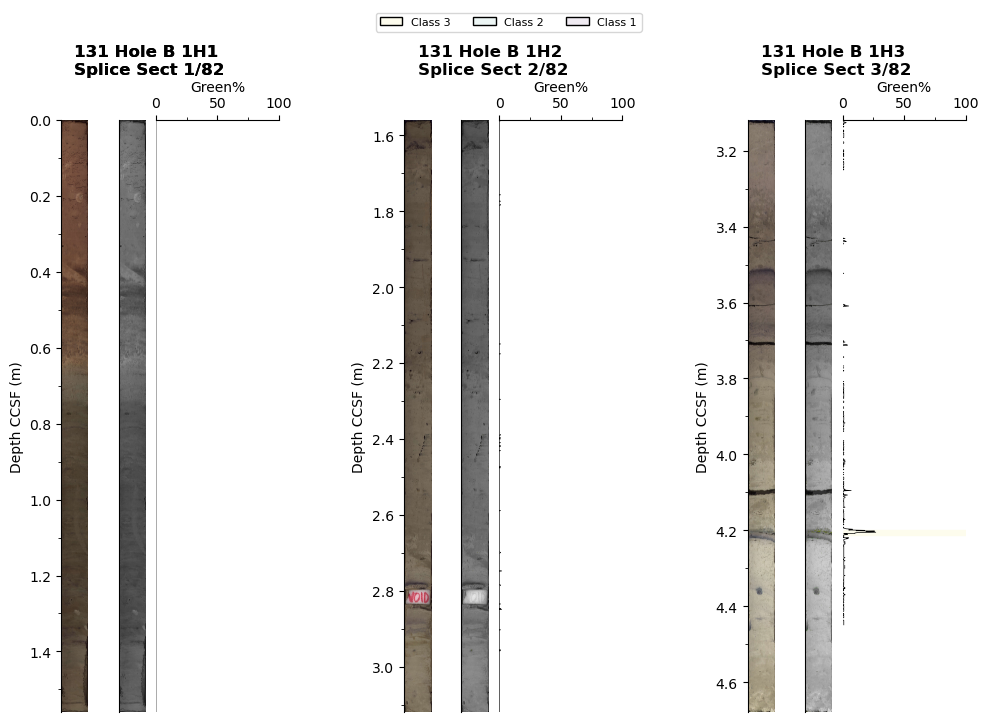

In [19]:
n1=0
n2=1
n3=2
fig=plt.figure(figsize=(11,8),facecolor='w')
gs = gridspec.GridSpec(1, 16, figure=fig,wspace=-.13,left=.1,right=.94,top=.84,bottom=.1)
makeLog(n1,'left')
makeLog(n2,'center')
makeLog(n3,'right')
fig.legend(handles=legend_elements,loc=(.38,.955),ncol=3,fontsize=8)

## Build PDF

In [20]:
end_sect=len(sections.loc[0:46])

In [21]:
nsall=iter(np.arange(0,end_sect+1).tolist())
znsall=zip(*[nsall]*3)

### All

In [22]:
from matplotlib.backends.backend_pdf import PdfPages
documents_path='/Users/danielbabin/GitHub/Green_Bands/Documents/Green_Band_Stratigraphy_Charts/'
with PdfPages(documents_path+'U1313 green band stratigraphy.pdf') as pdf:
    for n1,n2,n3 in znsall:
        clear_output(wait=True)
        fig=plt.figure(figsize=(11,8),facecolor='w')
        gs = gridspec.GridSpec(1, 16, figure=fig,wspace=-.13,left=.1,right=.94,top=.84,bottom=.1)
        makeLog(n1,'left')
        makeLog(n2,'center')
        makeLog(n3,'right')
        fig.legend(handles=legend_elements,loc=(.38,.955),ncol=3,fontsize=8)
        pdf.savefig(fig,dpi=900,orientation='landscape')
        plt.close()
        print(n1,'/',end_sect)
        del fig
        del gs

45 / 47
